# Helmholtz' equation in an annulus using Jaxfun with polar coordinates

In this demo we will solve Helmholtz' equation in an annulus domain using polar coordinates and spectral accuracy. Helmholtz' equation reads

$$
\nabla^2 u(x, y) + \alpha u(x, y) = f(x, y),\quad x, y \in \Omega
$$

where $\Omega = \{x, y \, | \,  r_0 < \sqrt{x^2 + y^2} < r_1\}$ and $r_0 < r_1$ are the inner and outer radii of the annulus. The parameter $\alpha$ is a constant and $f(x, y)$ is a real function. We use homogeneous Dirichlet boundary conditions on the entire boundary.

We start by importing necessary classes and functions

In [1]:
from jaxfun import *
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sympy as sp

We then create a polar coordinate system

In [2]:
r, theta = sp.symbols("r,theta", real=True, positive=True)
r0, r1 = sp.S.Half, 1
C = get_CoordSys("C", sp.Lambda((r, theta), (r * sp.cos(theta), r * sp.sin(theta))))

This coordinate system is further used to create a tensor product space, where the radial direction uses composite Legendre polynomials (basis functions $\psi_i=P_i-P_{i+2}$) and the angular direction uses Fourier exponentials.

In [3]:
R = FunctionSpace(
    20,
    Legendre.Legendre,
    bcs={"left": {"D": 0}, "right": {"D": 0}},
    domain=Domain(r0, r1),
    name="R",
    fun_str="phi",
)
F = FunctionSpace(20, Fourier.Fourier, name="F", fun_str="E")
P = TensorProductSpace((R, F), system=C, name="P")

To implement Helmholtz' equation we need test and trial functions for the tensor product space

In [4]:
u = TrialFunction(P, name="u")
v = TestFunction(P, name="v")

The test and trial functions are subclasses of the Sympy [Function](https://docs.sympy.org/latest/modules/core.html#sympy.core.function.Function)

In [5]:
sp.pprint(u)

u(x, y; P)


Here we see that the trial function `u` is a function of spatial coordinates `x` and `y`, and it is a trial function of the `P` function space. In computational coordinates `u` is a tensor product function using a tensor product between the trial functions from the one-dimensional `R` and `F` spaces. `u` is evaluated in computational coordinates using the `doit()` method

In [6]:
u.doit()

phi_k(r)*E_l(theta)

Notice that $\phi_k(r)$ is component $k$ of the trial functions of the radial coordinate and $E_l(\theta)=\exp(\imath \underline{l} \theta)$ is component $l$ of the complex exponentials. (We defined the function names "phi" and "E" when creating the spaces.) The trial function is actually an expansion

$$
u(x, y) = U(r, \theta) = \sum_{k=0}^{N-3}\sum_{l=0}^{N-1} \hat{u}_{kl} \phi_{k}(r) \exp(\imath \underline{l} \theta)
$$

where 

$$
\underline{l} = \begin{cases} l, \quad &\text{if} \, l < N/2 \\
-(N-l) \quad &\text{if} \, l \ge N/2
\end{cases}
$$

However, we do not print the expansion factors $\{\hat{u}_{kl}\}$, only the basis functions. The expansion factors are the unknown that we will compute in the end.

Helmholtz' equation is now

In [7]:
alpha = 1
eq = Div(Grad(u)) + alpha*u
sp.pprint(eq)

u(x, y; P) + ∇⋅(∇(u(x, y; P)))


Like the trial function we can also evaluate the equation in computational coordinates using `doit()`

In [8]:
sp.simplify(eq.doit())

phi_k(r)*E_l(theta) + E_l(theta)*Derivative(phi_k(r), (r, 2)) + E_l(theta)*Derivative(phi_k(r), r)/r + phi_k(r)*Derivative(E_l(theta), (theta, 2))/r**2

Notice that we get the Helmholtz equation in polar computational coordinates, and the trial functions are expanded into tensor products. It looks a bit better if we multiply through with the radius $r^2$:

In [9]:
r, theta = C.base_scalars()
sp.simplify((r**2*eq).doit())

r**2*phi_k(r)*E_l(theta) + r*(r*Derivative(phi_k(r), (r, 2)) + Derivative(phi_k(r), r))*E_l(theta) + phi_k(r)*Derivative(E_l(theta), (theta, 2))

If you want to see what the Helmholtz equation looks like with a regular (non-tensor-product) function, then you can create a `ScalarFunction` and use that instead of the trial function

In [10]:
h = arguments.ScalarFunction("h", C)
sp.simplify((Div(Grad(h))+alpha*h).doit())

H(r, theta) + Derivative(H(r, theta), (r, 2)) + Derivative(H(r, theta), r)/r + Derivative(H(r, theta), (theta, 2))/r**2

Notice that the scalar function use a lowercase letter in physical space and an upper case letter in computational space

$$
h(x, y) = H(r, \theta).
$$

In order to solve the Helmholtz equation we need to define $f(x, y)$ and assemble the inner products

$$
(\nabla^2u + \alpha u, v)_{L^2(\Omega)} = (f, v)_{L^2(\Omega)}
$$

Since the Fourier exponentials are complex functions we need to use a complex inner product defined as

$$
(a, b)_{L^2(\Omega)} = \int_{\Omega} \,a \, \overline{b}\, d\Omega,
$$

where $\overline{b}$ is the complex conjugate of $b$.

We can assemble both sides of Helmholtz' equation in one call. Here we actually assemble all terms in

$$
(\nabla^2 u + \alpha u - f, v)_{L^2(\Omega)} = 0
$$

In [11]:
f = 2
A, b = inner((eq-f)*sp.conjugate(v))

Now all matrices will be collected in `A`, whereas the right hand side vector is collected in `b`

In [12]:
A

In [13]:
b.shape

(18, 20)

The tensor product matrices in A are tensors with four indices, and each item is the outer product of two (1D) matrices. We can see which matrices there are by inspecting the equation in computational space

In [14]:
sp.simplify((eq*sp.conjugate(v)).doit())

(r**2*phi_k(r)*E_l(theta) + r*(r*Derivative(phi_k(r), (r, 2)) + Derivative(phi_k(r), r))*E_l(theta) + phi_k(r)*Derivative(E_l(theta), (theta, 2)))*conjugate(phi_i(r))*conjugate(E_j(theta))/r**2

Here the test function uses indices $i$ and $j$, whereas the trial function uses $k$ and $l$. Each term with four indices is one `TPMatrix` in `A`. As seen above, there are 4 tensor product matrices (4 items with 4 indices). Note that the complex conjugate of the test function is evaluated automatically inside the `inner` function and it is not necessary to call it explicitly as above. Hence `eq*v` would produce the same result, but it would not print as nicely (and correctly) as above.

In the end we assemble a Kronecker product matrix from all the items in `A` and then solve the linear system of equations:

In [15]:
C = jnp.sum(jnp.array([jnp.kron(*a.mats) for a in A]), axis=0)
uh = jnp.linalg.solve(C, b.flatten()).reshape(b.shape)

We can plot the solution in Cartesian coordinates on a uniform grid with 100 by 100 points:

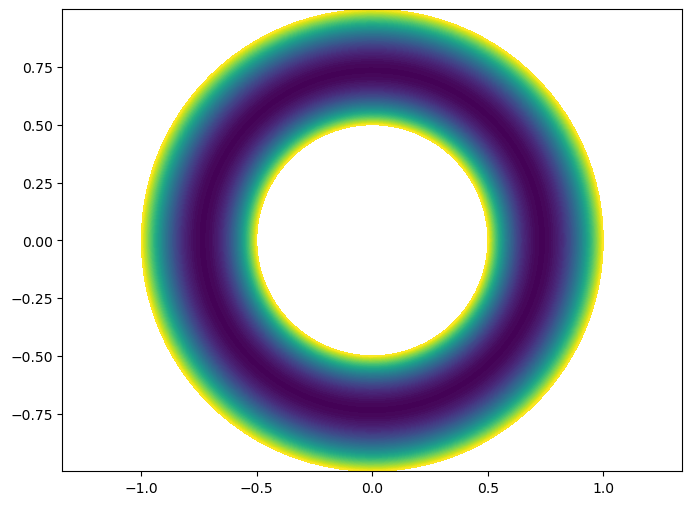

In [16]:
xc, yc = P.cartesian_mesh(kind="uniform", N=(100, 100))
uj = P.backward(uh, kind="uniform", N=(100, 100))
f = plt.figure(figsize=(8, 6))
ax = f.gca()
ax.contourf(xc, yc, uj.real, 50)
h = plt.axis('equal')